Exploratory Data Analysis

01. Load data

In [3]:
import pandas as pd

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\1667466518.py:4: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [4]:
# Edu: EXTRA metric 4:
# relacion volumen de cash reques contra reco creation y reco resolve. Los que piden poco han tenido incidencias más largas (recovery)


# "We analyzed the relationship between the volume of cash requests and the creation and resolution of recovery cases.
# Hypothesis to test: Users with fewer requests tend to experience longer recovery times.
#New Metric: XXXX
# Columns: 



In [5]:
#Function for showing data with seaborn:
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10, 6))
# sns.countplot(data=incident_feed, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x
# incident_feed.pivot.plot(kind='bar', stacked=True, colormap='viridis')
# plt.title('Fee Incidents by Cohort')
# plt.xlabel('Cohort')
# plt.ylabel('Fee Incidents')
# plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
# plt.tight_layout()
# plt.show()
    
    

02. Checks on Timestamnps data types and drop of incomplete records from the scope of this analysis

In [6]:
#Hypothesis Test: "Users with fewer requests are prone to experience longer recovery times."
    
#Drop rows with null timestamps
fees_and_cohorts_df['reco_creation'] = pd.to_datetime(fees_and_cohorts_df['reco_creation'], errors='coerce')
fees_and_cohorts_df['reco_last_update'] = pd.to_datetime(fees_and_cohorts_df['reco_last_update'], errors='coerce')

# Only keep completed recoveries for clear duration measurement
fees_and_cohorts_df_completed = fees_and_cohorts_df[fees_and_cohorts_df['recovery_status'] == 'completed'].copy()

# Drop incomplete data
fees_and_cohorts_df_completed.dropna(subset=['reco_creation', 'reco_last_update', 'total_amount', 'user_id'], inplace=True)



3. Calculate Recovery Duration

In [7]:
#For each completed recovery case:
# recovery_duration = reco_last_update - reco_creation (in days)

fees_and_cohorts_df_completed['recovery_duration_days'] = (fees_and_cohorts_df_completed['reco_last_update'] - fees_and_cohorts_df_completed['reco_creation']).dt.days


Validating results

In [8]:
fees_and_cohorts_df_completed['recovery_duration_days'].sample(10)

44       117
9094       0
1921       1
17275     17
2550       9
7902      43
7216      16
743       19
3755      17
20106     26
Name: recovery_duration_days, dtype: int64

In [9]:
fees_and_cohorts_df_completed['recovery_duration_days'].describe()


count    4945.000000
mean       23.126997
std        31.929807
min         0.000000
25%         1.000000
50%        12.000000
75%        27.000000
max       202.000000
Name: recovery_duration_days, dtype: float64

4. Group by user_id

    Count number of requests (rows) per user
    Average recovery duration per user

In [10]:
agg_fees_and_cohorts_df_completed = fees_and_cohorts_df_completed.groupby('user_id').agg(num_requests=('cash_request_id', 'count'),avg_recovery_duration=('recovery_duration_days', 'mean')).reset_index()


In [11]:
#results validation:
agg_fees_and_cohorts_df_completed.describe()


,user_id,num_requests,avg_recovery_duration
count,2021.000000,2021.000000,2021.000000
mean,38429.328550,2.446809,18.612790
std,28228.605533,2.116125,26.029534
min,72.000000,1.000000,0.000000
25%,15219.000000,1.000000,1.000000
50%,31026.000000,2.000000,11.000000
75%,56899.000000,3.000000,22.000000
max,103496.000000,28.000000,202.000000


5. Correlation Analysis

Use statistical correlation metrics like:

    . Pearson correlation
    . Spearman correlation (in case of non-linear monotonic relationship)

In [12]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(agg_fees_and_cohorts_df_completed['num_requests'], agg_fees_and_cohorts_df_completed['avg_recovery_duration'])
spearman_corr, _ = spearmanr(agg_fees_and_cohorts_df_completed['num_requests'], agg_fees_and_cohorts_df_completed['avg_recovery_duration'])


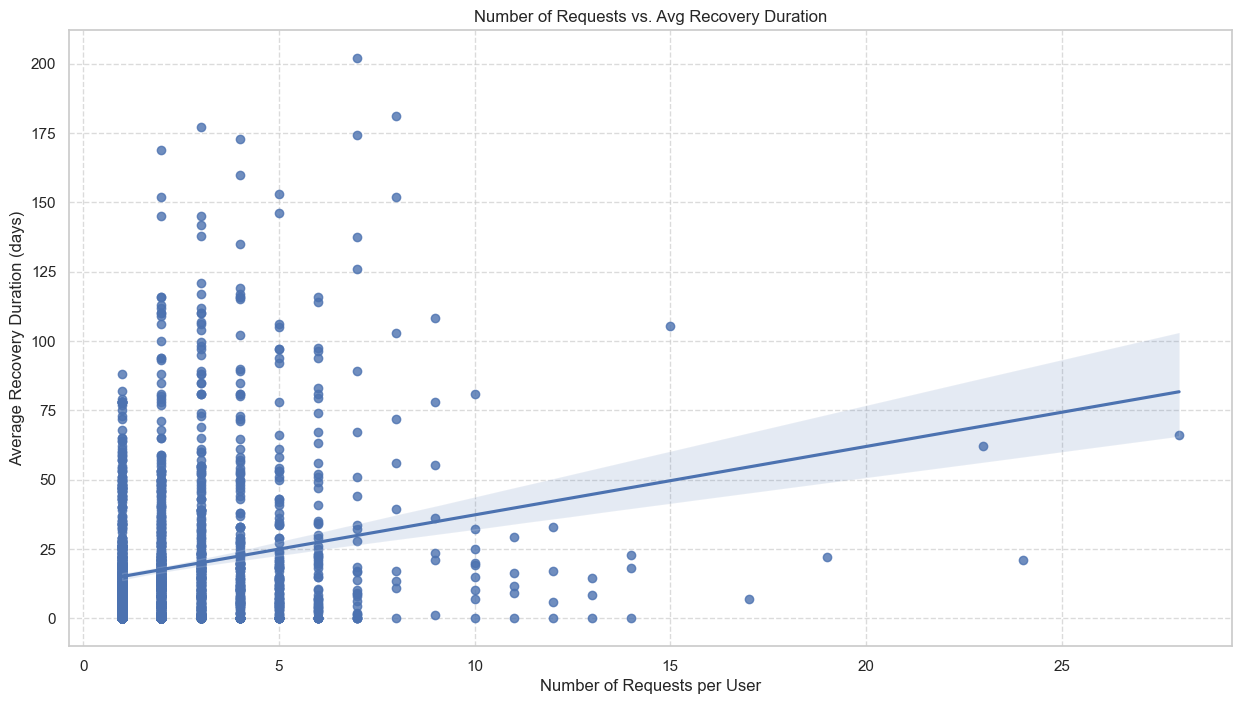

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.grid(True, linestyle='--', alpha=0.7)
sns.regplot(x='num_requests', y='avg_recovery_duration', data=agg_fees_and_cohorts_df_completed)
plt.title("Number of Requests vs. Avg Recovery Duration")
plt.xlabel("Number of Requests per User")
plt.ylabel("Average Recovery Duration (days)")
plt.show()


Conclussions:

1. For users with few requests (e.g., 1 to 5), there's a much wider spread in recovery durations — including some very high values (100–200 days).
2. For users with many requests, recovery durations are more tightly clustered around lower values.


Higher variability and higher potential for extreme durations happen among users with fewer requests.
This could mean:

    There may be subgroups worth isolating (e.g., segmenting by number of requests).
    A non-linear relationship or heteroscedasticity is present — which would break assumptions of linear regression.

Next Steps:

    1. Plot a violin plot or box plot by buckets of request count:
        Helps visualize distributions per group (e.g., 1-2, 3-5, 6-10, etc.)

    2. Use log transformation or quantile analysis:
        To better capture non-linear or skewed patterns.

    3. Check variance across request bins:
        Validate if fewer-request users truly have more erratic durations.

    4. Use non-parametric tests like Kruskal-Wallis:
        To compare medians across bins without assuming normality.

Plan for Correlation Analysis

We will:

    Compute request volume per user from cashreq_df.
    Compute average recovery time per user from fees_df using:
    reco_last_update - reco_creation
    Merge both metrics per user.

    Visualize and calculate correlation coefficient (e.g., Pearson's r).

In [14]:
import numpy as np

import pandas as pd

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

# Step 1: Compute request volume per user
request_volume = cashrequest_df.groupby("user_id").size().reset_index(name="request_count")

# Step 2: Compute recovery time per fee entry, and average per user
fees_and_cohorts_df["reco_creation"] = pd.to_datetime(fees_and_cohorts_df["reco_creation"], errors="coerce")
fees_and_cohorts_df["reco_last_update"] = pd.to_datetime(fees_and_cohorts_df["reco_last_update"], errors="coerce")
fees_and_cohorts_df["recovery_duration"] = (fees_and_cohorts_df["reco_last_update"] - fees_and_cohorts_df["reco_creation"]).dt.total_seconds() / 3600  # in hours

# Filter to relevant and valid recovery durations
valid_recovery = fees_and_cohorts_df.dropna(subset=["recovery_duration", "user_id"])

# Step 3: Average recovery time per user
avg_recovery_time = valid_recovery.groupby("user_id")["recovery_duration"].mean().reset_index(name="avg_recovery_hours")

# Step 4: Merge both metrics
user_metrics = pd.merge(request_volume, avg_recovery_time, on="user_id")

# Show resulting dataset
user_metrics.head()
print(user_metrics)

# Step 5: Compute correlation
correlation = user_metrics["request_count"].corr(user_metrics["avg_recovery_hours"])
correlation

      user_id  request_count  avg_recovery_hours
0          72             12        8.257317e+02
1         114             11        2.059292e+02
2         204              4        3.136285e+02
3         213              8        3.319380e+03
4         277              5        4.991016e+02
...       ...            ...                 ...
2697   102923              1        3.393132e+02
2698   103174              1        2.777778e-09
2699   103390              1        8.293345e+02
2700   103425              1        5.709178e+02
2701   103496              1        1.978751e+02

[2702 rows x 3 columns]


C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\3458024576.py:6: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


np.float64(-0.02409948649654688)

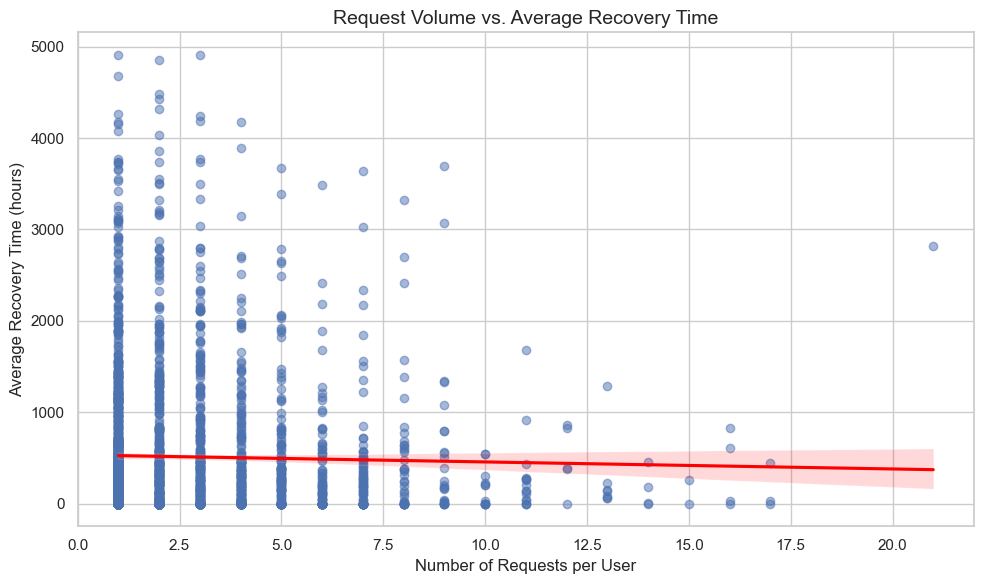

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for better aesthetics
sns.set(style="whitegrid")

# Create scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=user_metrics,
    x="request_count",
    y="avg_recovery_hours",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

# Titles and labels
plt.title("Request Volume vs. Average Recovery Time", fontsize=14)
plt.xlabel("Number of Requests per User")
plt.ylabel("Average Recovery Time (hours)")
plt.tight_layout()
plt.show()



Handling Outliers

<Axes: ylabel='avg_recovery_hours'>

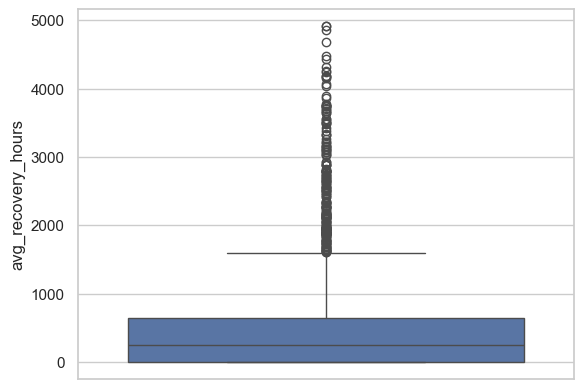

In [16]:
sns.boxplot(data=user_metrics, y="avg_recovery_hours")

✂️ B. Remove Outliers Using IQR

In [17]:
Q1 = user_metrics["avg_recovery_hours"].quantile(0.25)
Q3 = user_metrics["avg_recovery_hours"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_metrics = user_metrics[(user_metrics["avg_recovery_hours"] >= lower_bound) &
                                (user_metrics["avg_recovery_hours"] <= upper_bound)]


Handling Data Imbalance

Most users likely have very few requests. To deal with this:

In [18]:
filtered_metrics["request_bucket"] = pd.cut(
    filtered_metrics["request_count"],
    bins=[0, 1, 3, 5, 10, 20],
    labels=["1", "2-3", "4-5", "6-10", "11-20"]
)


C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\4011804481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metrics["request_bucket"] = pd.cut(


B. Plot Mean per Bucket

<Axes: xlabel='request_bucket', ylabel='avg_recovery_hours'>

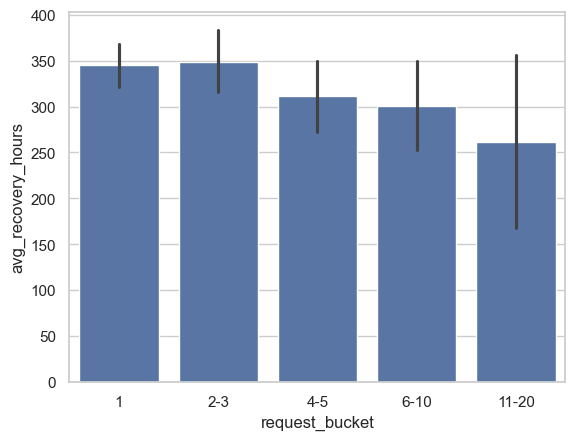

In [19]:
sns.barplot(data=filtered_metrics, x="request_bucket", y="avg_recovery_hours")


C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\1988550078.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=filtered_metrics, x="request_bucket", y="avg_recovery_hours", ci="sd")


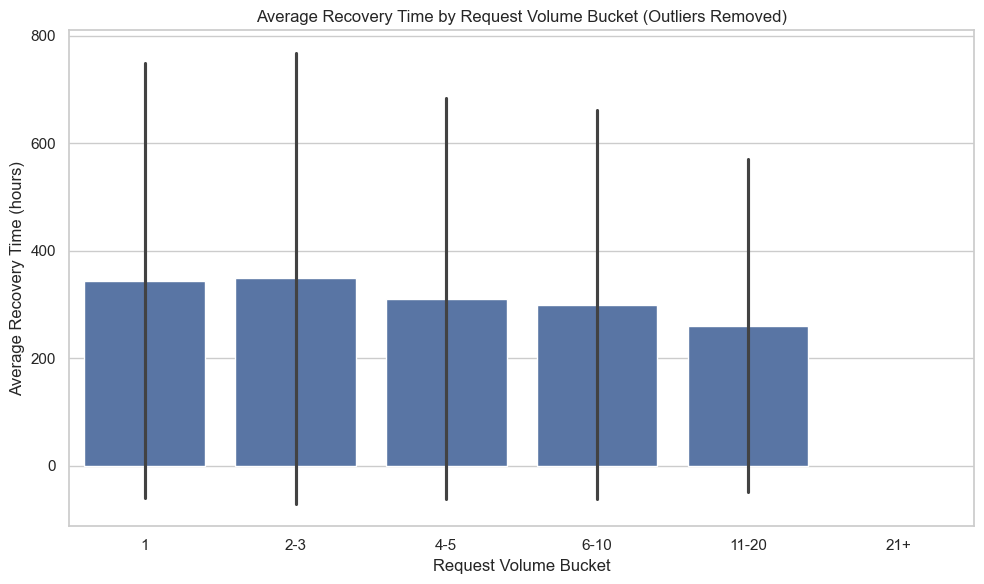

In [20]:
# Step 1: Remove outliers using IQR method
Q1 = user_metrics["avg_recovery_hours"].quantile(0.25)
Q3 = user_metrics["avg_recovery_hours"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_metrics = user_metrics[
    (user_metrics["avg_recovery_hours"] >= lower_bound) &
    (user_metrics["avg_recovery_hours"] <= upper_bound)
].copy()

# Step 2: Group request_count into buckets
filtered_metrics["request_bucket"] = pd.cut(
    filtered_metrics["request_count"],
    bins=[0, 1, 3, 5, 10, 20, 100],
    labels=["1", "2-3", "4-5", "6-10", "11-20", "21+"],
    include_lowest=True
)

# Step 3: Plot average recovery time per bucket
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_metrics, x="request_bucket", y="avg_recovery_hours", ci="sd")

plt.title("Average Recovery Time by Request Volume Bucket (Outliers Removed)")
plt.xlabel("Request Volume Bucket")
plt.ylabel("Average Recovery Time (hours)")
plt.tight_layout()
plt.show()


Each bar shows the average recovery time (in hours) for users in that request volume bucket.

Error bars show standard deviation, indicating variability in recovery times.

C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\813611153.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\edumc\AppData\Local\Temp\ipykernel_50248\813611153.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


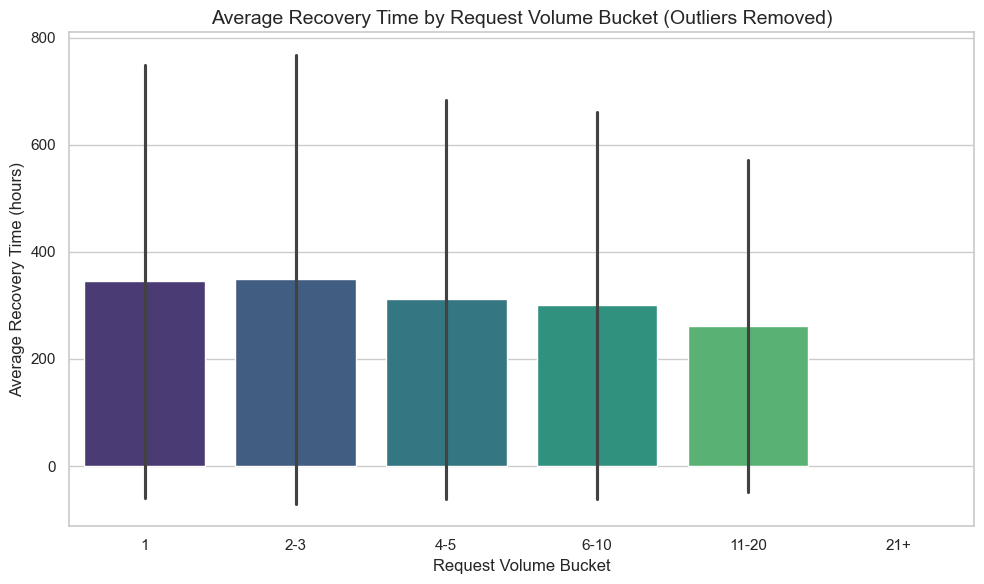

In [26]:
# Plot again using viridis color palette (called "viridis" in seaborn/matplotlib)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_metrics,
    x="request_bucket",
    y="avg_recovery_hours",
    ci="sd",
    palette="viridis"
)

plt.title("Average Recovery Time by Request Volume Bucket (Outliers Removed)", fontsize=14)
plt.xlabel("Request Volume Bucket")
plt.ylabel("Average Recovery Time (hours)")
plt.tight_layout()
plt.show()
